[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[*********************100%***********************]  1 of 1 completed

Average Sentiment Score: 0.05198190793551618


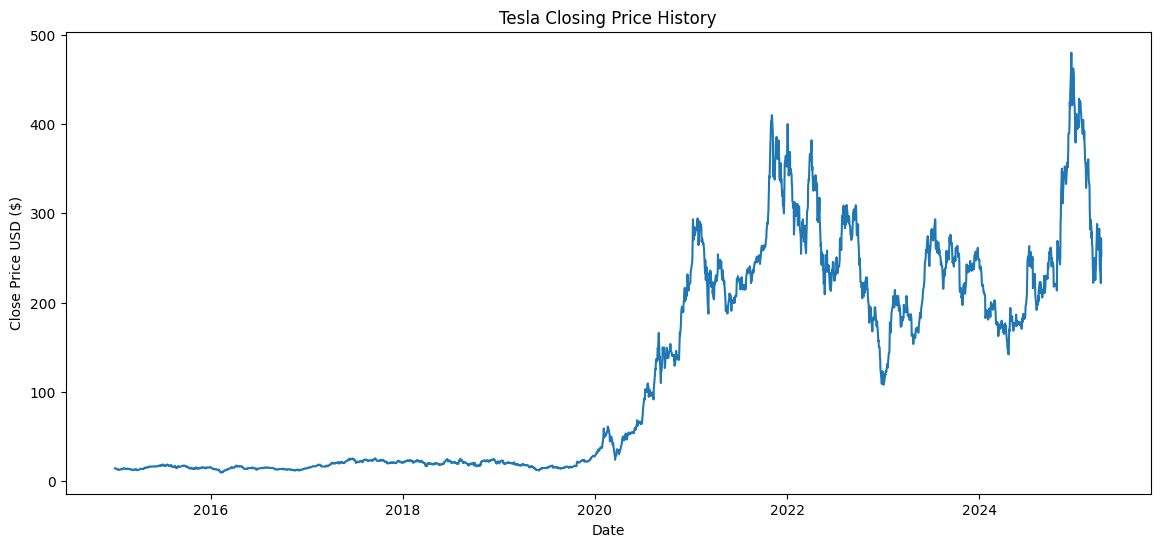

Column names after cleaning: ['close_tsla', 'high_tsla', 'low_tsla', 'open_tsla', 'volume_tsla']
Using column for closing prices: close_tsla
X_train shape: (2008, 60, 2)
y_train shape: (2008,)
Epoch 1/50


e:\lstm_sentiment_analysis\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0205
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.2579e-04
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.5293e-04
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 7.3627e-04
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.6710e-04
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.7535e-04
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.6912e-04
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.4024e-04
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 4.7465e-04
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.9663e-04
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 4.0472e-04
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.9914e-04
Epoch 13/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.6870e-04
Epoch 14/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.5678e-04
Epoch 15/50
63/63 ━━━━━━━━━━━━

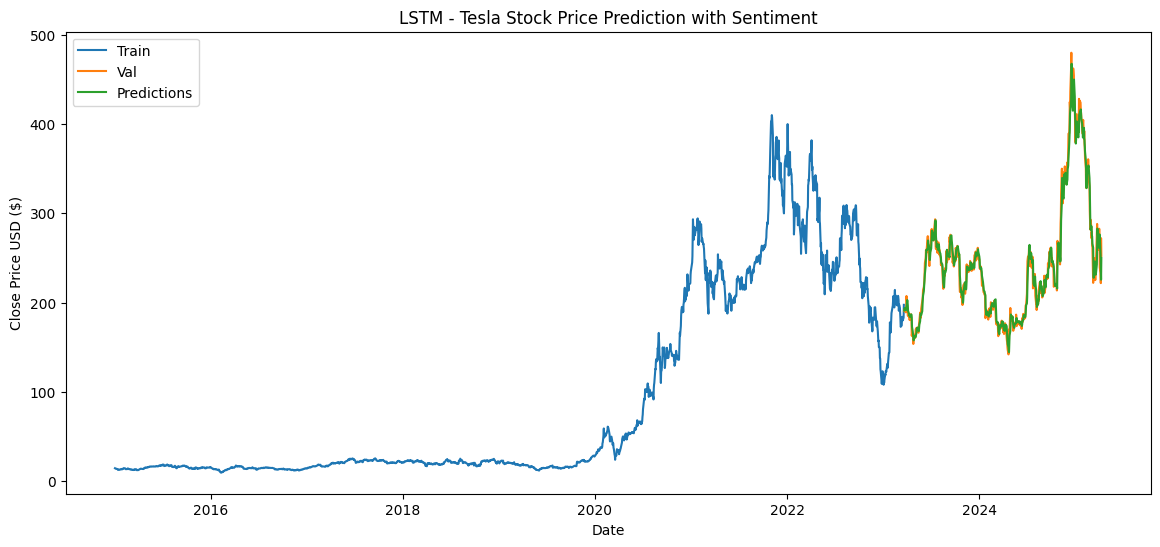

           Date  Predicted Price  Lower Bound  Upper Bound
2584 2025-04-11           256.04       222.76       289.33
2585 2025-04-14           257.44       223.97       290.90
2586 2025-04-15           257.37       223.92       290.83
2587 2025-04-16           257.06       223.64       290.47
2588 2025-04-17           256.89       223.49       290.28
2589 2025-04-18           256.91       223.51       290.31
2590 2025-04-21           257.06       223.64       290.48
2591 2025-04-22           257.27       223.82       290.71
2592 2025-04-23           257.48       224.00       290.95
2593 2025-04-24           257.67       224.17       291.16
2594 2025-04-25           257.83       224.31       291.35
2595 2025-04-28           257.97       224.43       291.50
2596 2025-04-29           258.09       224.54       291.64
2597 2025-04-30           258.19       224.63       291.76
2598 2025-05-01           258.29       224.71       291.86
Forecast with sentiment data exported to 'stock_lstm_for

In [8]:
import requests
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from textblob import TextBlob
from datetime import datetime, timedelta
import nltk

# Download NLTK data
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Function to fetch news articles using NewsAPI
def fetch_tesla_news(api_key, days_back=7):
    url = "https://newsapi.org/v2/everything"
    end_date = datetime.now()
    start_date = end_date - timedelta(days=days_back)
    
    params = {
        'q': 'Tesla',
        'from': start_date.strftime('%Y-%m-%d'),
        'to': end_date.strftime('%Y-%m-%d'),
        'sortBy': 'publishedAt',
        'apiKey': api_key,
        'language': 'en'
    }
    
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        articles = data.get('articles', [])
        return articles
    else:
        print(f"Error fetching news: {response.status_code}")
        return []

# Function to perform sentiment analysis
def analyze_sentiment(text):
    blob = TextBlob(text)
    sentiment_score = blob.sentiment.polarity
    if sentiment_score > 0:
        return 'Positive', sentiment_score
    elif sentiment_score < 0:
        return 'Negative', sentiment_score
    else:
        return 'Neutral', sentiment_score

# Fetch and compute average sentiment score
api_key = '8fa805af31b54a0ab98c3d5e804f49df'
news_articles = fetch_tesla_news(api_key)

news_data = []
for article in news_articles:
    title = article.get('title', 'No title')
    description = article.get('description', 'No description') if article.get('description') else 'No description'
    content = title + " " + description
    sentiment_label, sentiment_score = analyze_sentiment(content)
    news_data.append(sentiment_score)

average_sentiment = np.mean(news_data) if news_data else 0.0
print(f"Average Sentiment Score: {average_sentiment}")

# Download Tesla stock data
df = yf.download('TSLA', start='2015-01-01', end='2025-04-11')

# Visualize closing price
plt.figure(figsize=(14, 6))
plt.plot(df['Close'])
plt.title('Tesla Closing Price History')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.show()

# Step 1: Clean column names
if isinstance(df.columns, pd.MultiIndex):
    df.columns = ['_'.join(col).strip().lower() for col in df.columns.values]
else:
    df.columns = df.columns.str.strip().str.lower()

print("Column names after cleaning:", df.columns.tolist())

# Step 2: Locate the 'close' column
close_candidates = [col for col in df.columns if 'close' in col]
if not close_candidates:
    raise KeyError("No column containing 'close' found. Please check column names.")
close_col = close_candidates[0]
print("Using column for closing prices:", close_col)

# Step 3: Drop NA and select the close column
df = df.dropna(subset=[close_col])
data = df[[close_col]]
dataset = data.values

# Step 4: Scale the dataset to 0-1 and add sentiment as a feature
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Extend scaled_data with sentiment (repeat average_sentiment for the last 60 days)
sentiment_array = np.full((len(scaled_data), 1), average_sentiment)
combined_data = np.hstack((scaled_data, sentiment_array))

# Step 5: Prepare training data (80% for training)
training_data_len = int(np.ceil(len(combined_data) * 0.8))
train_data = combined_data[0:training_data_len]

X_train, y_train = [], []

for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, :])  # Include sentiment in the window
    y_train.append(train_data[i, 0])       # Predict the close price

# Convert to numpy arrays and reshape
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

# Final shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# Build and train the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(60, 2)))  # 2 features: close + sentiment
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=32)

# Create test data
test_data = combined_data[training_data_len - 60:]
X_test, y_test = [], dataset[training_data_len:]

for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, :])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Predict
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(np.hstack((predictions, np.full((predictions.shape[0], 1), average_sentiment))))[:, 0]

# Plotting
train = data[:training_data_len]
valid = data[training_data_len:].copy()

valid['Predictions'] = predictions

plt.figure(figsize=(14, 6))
plt.title('LSTM - Tesla Stock Price Prediction with Sentiment')
plt.plot(train[close_col], label='Train')
plt.plot(valid[[close_col, 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'])
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.show()

# Forecast future prices with sentiment
last_60_days = combined_data[-60:]
future_input = last_60_days.reshape(1, 60, 2)
future_predictions = []

for _ in range(15):
    pred = model.predict(future_input, verbose=0)[0][0]
    future_predictions.append(pred)
    # Shift the window and add the new prediction with the same sentiment
    future_input = np.append(future_input[:, 1:, :], [[[pred, average_sentiment]]], axis=1)

future_predictions = scaler.inverse_transform(np.hstack((np.array(future_predictions).reshape(-1, 1), np.full((len(future_predictions), 1), average_sentiment))))[:, 0]

# Create bounds
lower_bounds = future_predictions * 0.87
upper_bounds = future_predictions * 1.13

# Generate future business dates
df.index = pd.to_datetime(df.index)
df = df.sort_index()
last_date = df.index[-1]
start_date = pd.bdate_range(start=last_date + timedelta(days=1), periods=1)[0]
future_dates = pd.date_range(start=start_date, periods=15, freq='B')

# Create forecast DataFrame
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Price': future_predictions,
    'Lower Bound': lower_bounds,
    'Upper Bound': upper_bounds
})

forecast_df.index = range(len(df), len(df) + 15)

# Display result
print(forecast_df.round(2))

# Export to CSV
forecast_df.to_csv("stock_lstm_forecast_with_sentiment.csv", index=False)
print("Forecast with sentiment data exported to 'stock_lstm_forecast_with_sentiment.csv'")

# Export sentiment analysis to CSV
news_df = pd.DataFrame(news_data, columns=['Sentiment Score'])
news_df.to_csv("tesla_news_sentiment.csv", index=False)
print("News sentiment data exported to 'tesla_news_sentiment.csv'")
